Загрузим базу данных в фрейм и выведем несколько строк

In [515]:
import pandas as pd
titanic_f = pd.read_csv('titanic.csv')
titanic_f.sample(6)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
532,0,3,male,17.0,1,1,7.2292,C,Third,man,True,NaN,Cherbourg,no,False
520,1,1,female,30.0,0,0,93.5000,S,First,woman,False,B,Southampton,yes,True
183,1,2,male,1.0,2,1,39.0000,S,Second,child,False,F,Southampton,yes,False
63,0,3,male,4.0,3,2,27.9000,S,Third,child,False,NaN,Southampton,no,False
841,0,2,male,16.0,0,0,10.5000,S,Second,man,True,NaN,Southampton,no,True
582,0,2,male,54.0,0,0,26.0000,S,Second,man,True,NaN,Southampton,no,True


Выведем информацию о базе данных, чтобы узнать о её структуре и количестве пустых ячеек

In [516]:
titanic_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


Выведем таблицу столбцов, в которых есть пропуски и построим диаграмму, чтобы было проще анализировать

In [517]:
leak = pd.isnull(titanic_f).sum()
leak = leak[leak != 0].sort_values(ascending=False)
leak.name = 'leak'
known = leak.map(lambda x: len(titanic_f) - x)
known.name = 'known'
leak

deck           688
age            177
embarked         2
embark_town      2
Name: leak, dtype: int64

<AxesSubplot:>

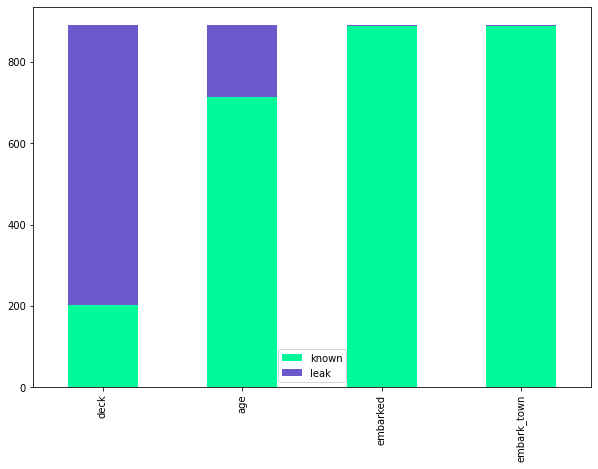

In [518]:
pd.DataFrame({x.name: x for x in [known, leak]}).plot.bar(stacked=True, figsize=(10, 7),
                                                          color=['mediumspringgreen', 'slateblue'])

В последних 2х столбцах заменим пустые значения на моду, а во 2м на медианы среди детей, женщин и мужчин

In [519]:
titanic_f['embarked'].fillna(titanic_f['embarked'].mode()[0], inplace=True)
titanic_f['embark_town'].fillna(titanic_f['embark_town'].mode()[0], inplace=True)
titanic_f['age'].fillna(titanic_f.groupby(['who'])['age'].transform('median'), inplace=True)

В 1м столбце слишком много пропусков, поэтому проанализируем зависимость палубы от класса билета

In [520]:
pvt = titanic_f.pivot_table(index=['class'], columns=['deck'], values='pclass', aggfunc='count')
pvt

deck,A,B,C,D,E,F,G
class,,,,,,,
First,15.0,47.0,59.0,29.0,25.0,NaN,NaN
Second,NaN,NaN,NaN,4.0,4.0,8.0,NaN
Third,NaN,NaN,NaN,NaN,3.0,5.0,4.0


<AxesSubplot:xlabel='class'>

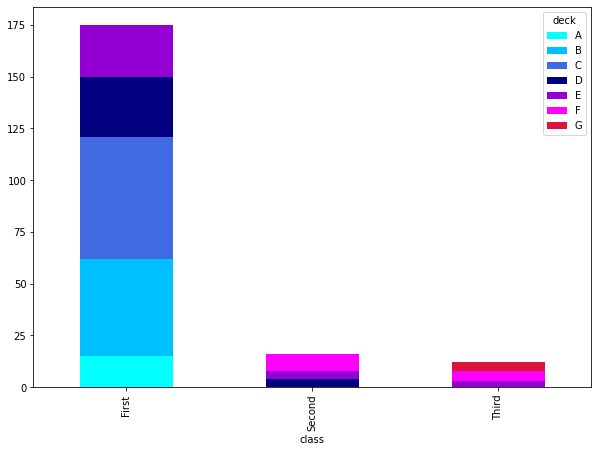

In [521]:
pvt.fillna(0).plot.bar(stacked=True, figsize=(10, 7),
                       color=['cyan', 'deepskyblue', 'royalblue', 'navy', 'darkviolet', 'magenta', 'crimson'])

Так как данных для людей с билетами 1го класса много, распределим их пропорционально, остальных расределим случайным образом среди палуб, в которых были пассажиры с билетами этих классов, можно было бы использовать какие-нибудь средние, но тогда получился бы перебор на некоторых палубах

In [522]:
from random import choices as chs


first = pvt.loc['First'].dropna()
ws = [first.tolist(), [1, 1, 1]]
vs = [first.index.tolist(), pvt.loc['Second'].dropna().index.tolist(), pvt.loc['Third'].dropna().index.tolist()]
for i in titanic_f.index:
    if not(isinstance(titanic_f.deck[i], str)):
        titanic_f.loc[i, 'deck'] = chs(vs[titanic_f.pclass[i] - 1], weights=ws[titanic_f.pclass[i] // 2])[0]

Полюбуемся распределением

<AxesSubplot:xlabel='class'>

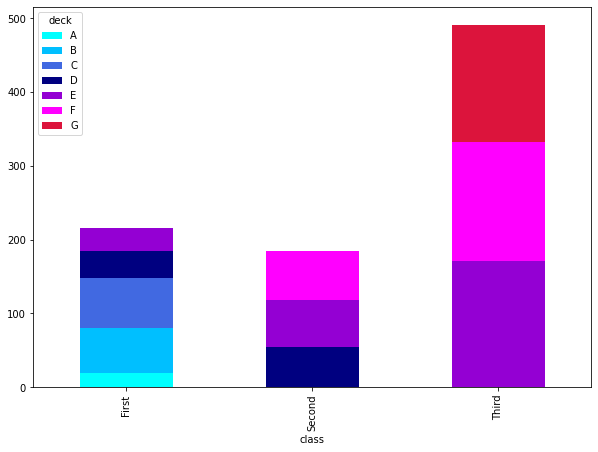

In [523]:
titanic_f.pivot_table(index=['class'], columns=['deck'], values='pclass', aggfunc='count').fillna(0).plot.bar(stacked=True, figsize=(10, 7), color=['cyan', 'deepskyblue', 'royalblue', 'navy', 'darkviolet', 'magenta', 'crimson'])

Убедимся, что пустых ячеек не осталось

In [524]:
last_leak = pd.isnull(titanic_f).sum()
last_leak = last_leak[last_leak != 0].sort_values(ascending=False)
last_leak.name = 'there are no empty values here'
last_leak

Series([], Name: there are no empty values here, dtype: int64)

Ответим на вопросы 3го номера

In [525]:
ct = {'male': len(titanic_f[titanic_f.sex == 'male'])}
ct['female'] = len(titanic_f) - ct['male']
print("a. Мужчин больше: {0} > {1}".format(ct['male'], ct['female']))
print("b. {0:2.0f}%".format(100 * sum(titanic_f['adult_male']) / len(titanic_f)))
print("c. 1й: {0}, 2й: {1}, 3й: {2}".format(len(titanic_f[titanic_f.pclass == 1]),
                                            len(titanic_f[titanic_f.pclass == 2]),
                                            len(titanic_f[titanic_f.pclass == 3])))

a. Мужчин больше: 577 > 314
b. 60%
c. 1й: 216, 2й: 184, 3й: 491


Проанализируем заполненную таблицу

In [526]:
titanic_f.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.758889,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002570,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Средний возраст выживших легче будет найти по таблице выживших(5е задание)
Наиболее интересные выводы по этой таблице:
    Самому старому пассажиру было 80 лет
    Средний возраст на борту составлял 29 лет
    Выживаемость в среднем равна 38%


Найдем распределение детей, мужчин и женщин по классам

In [527]:
cpvt = titanic_f.pivot_table(index=['who'], columns=['class'], values='pclass',
                             aggfunc=lambda x: x.count())
cw = {'man': len(titanic_f[titanic_f.who == 'man']), 'woman': len(titanic_f[titanic_f.who == 'woman']),
      'child': len(titanic_f[titanic_f.who == 'child'])}
for x in cpvt.index:
    cpvt.loc[x] = list(map(lambda z: z / cw[x], cpvt.loc[x]))
cpvt

class,First,Second,Third
who,,,
child,0.072289,0.228916,0.698795
man,0.221601,0.184358,0.594041
woman,0.335793,0.243542,0.420664


<AxesSubplot:xlabel='class'>

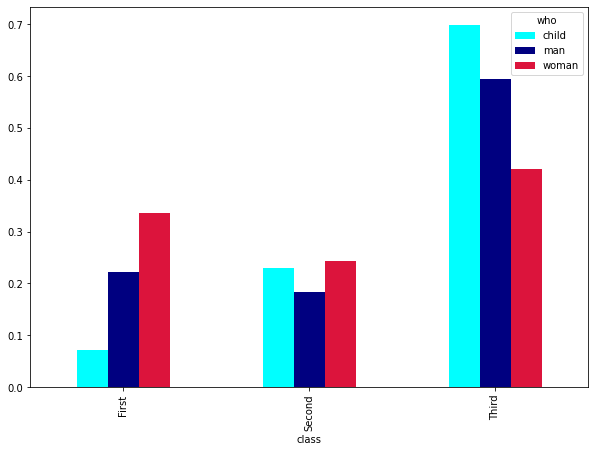

In [528]:
cpvt.T.plot.bar(figsize=(10, 7), color=['cyan', 'navy', 'crimson'])

По этой диаграмме можно заметить, что женщины чаще мужчин и детей плыли билетом 1 или 2 класса, а среди детей преобладают билеты 3го класса, но в большая часть каждой из категорий плыла 3м классом

In [529]:
titanic_f.groupby(['who'])['age'].median()

who
child     5.0
man      30.0
woman    30.0
Name: age, dtype: float64

По этой таблице можно увидеть средний возраст(медиану) для детей, мужчин и женщин

In [530]:
emb = {'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'}
cl = ['First', 'Second', 'Third']
sd = ['no', 'yes']
al = lambda x: False if (x.parch + x.sibsp != 0) else True
f = len(titanic_f[titanic_f.adult_male]) == len(titanic_f[titanic_f.who == 'man'])
for i in titanic_f.index:
    f = f and (emb[titanic_f.loc[i]['embarked']] == titanic_f.loc[i]['embark_town']) and (cl[titanic_f.loc[i]['pclass'] - 1] == titanic_f.loc[i]['class']) and (sd[titanic_f.loc[i]['survived']] == titanic_f.loc[i]['alive']) and (al(titanic_f.loc[i]) == titanic_f.loc[i].alone)
if f:
    print('Столбцы "embarked" и "embark_town", "class" и "pclass", "survived" и "alive" идентичны, а информация в столбцах "adult_male" и "alone" однозначно определяется по столбцам "who" и "parch" с "sibsp" соответственно, скорее всего они идентичны')

Столбцы "embarked" и "embark_town", "class" и "pclass", "survived" и "alive" идентичны, а информация в столбцах "adult_male" и "alone" однозначно определяется по столбцам "who" и "parch" с "sibsp" соответственно, скорее всего они идентичны


Создадим таблицу с выжившими и импортируем из нее данные в новый фрейм

In [531]:
tbl = titanic_f[titanic_f.survived == 1].copy()
tbl.to_csv("survived.csv", index=False)
srvd = pd.read_csv("survived.csv")
srvd

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
1,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,E,Southampton,yes,True
2,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
3,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,E,Southampton,yes,False
4,1,2,female,14.0,1,0,30.0708,C,Second,child,False,E,Cherbourg,yes,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,1,3,female,15.0,0,0,7.2250,C,Third,child,False,G,Cherbourg,yes,True
338,1,1,female,56.0,0,1,83.1583,C,First,woman,False,C,Cherbourg,yes,False
339,1,2,female,25.0,0,1,26.0000,S,Second,woman,False,F,Southampton,yes,False
340,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True


Сразу же ответим на вопрос из 4го задания

In [532]:
print('Средний возраст выживших: {0:2.0f}'.format(srvd.age.mean()))

Средний возраст выживших: 29


Проанализируем связь выживаемости и различных показателей, создадим фрейм и построим диаграмму, на которой будет видна доля детей, женщин и мужчин сначала для всех пассажиров титаника, а затем только для выживших

In [533]:
twsd = titanic_f.groupby(['who'])['age'].count()
for i in twsd.index:
    twsd.loc[i] /= len(titanic_f)
twsd

who
child    0.093154
man      0.602694
woman    0.304153
Name: age, dtype: float64

<AxesSubplot:xlabel='who'>

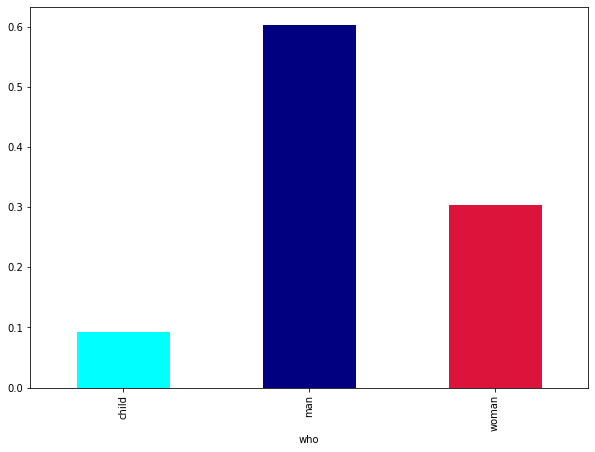

In [534]:
twsd.T.plot.bar(figsize=(10, 7), color=['cyan', 'navy', 'crimson'])

In [535]:
wsd = srvd.groupby(['who'])['age'].count()
for i in wsd.index:
    wsd.loc[i] /= len(srvd)
wsd

who
child    0.143275
man      0.257310
woman    0.599415
Name: age, dtype: float64

<AxesSubplot:xlabel='who'>

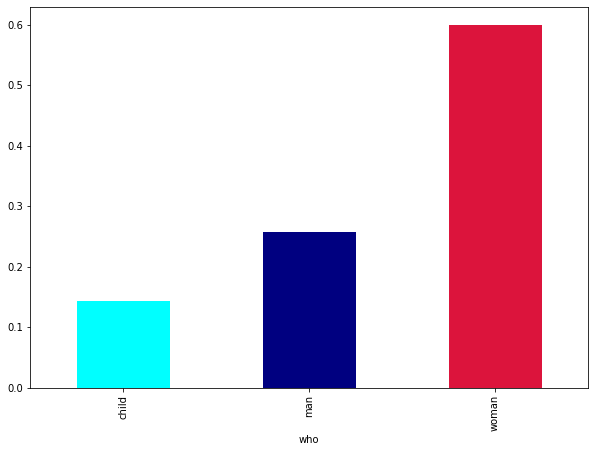

In [536]:
wsd.T.plot.bar(figsize=(10, 7), color=['cyan', 'navy', 'crimson'])

Выведем на одном графике сколько людей было и сколько из них выжило

In [537]:
d = srvd.groupby(['who'])['age'].count()
t = titanic_f.groupby(['who'])['age'].count()
l_df = pd.DataFrame({'survived': d, 'lost': [t.loc[x] - d.loc[x] for x in t.index]})
l_df

,survived,lost
who,,
child,49,34
man,88,449
woman,205,66


<AxesSubplot:xlabel='who'>

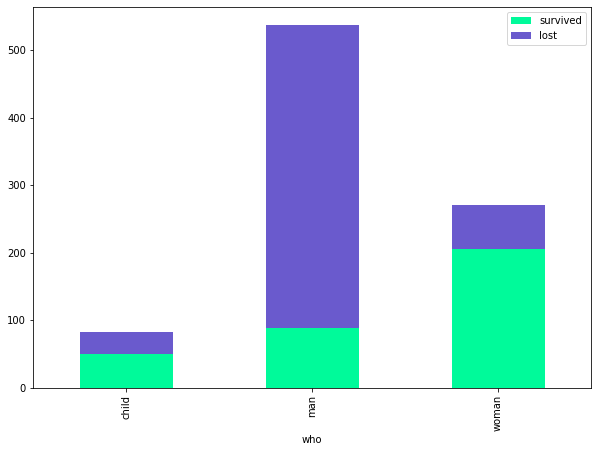

In [538]:
l_df.plot.bar(stacked=True, figsize=(10, 7), color=['mediumspringgreen', 'slateblue'])

In [539]:
print("Так изменился процент взрослых мужчин: было {0:2.0f}, стало {1:2.0f}".format(twsd['man'] * 100, wsd['man'] * 100))

Так изменился процент взрослых мужчин: было 60, стало 26


In [540]:
print("Из {0} мужчин выжило {1}, из {2} женщин выжило {3}, из {4} детей выжило {5}".format(l_df.loc['man'].sum(), l_df.loc['man']['survived'], l_df.loc['woman'].sum(), l_df.loc['woman']['survived'], l_df.loc['child'].sum(), l_df.loc['child']['survived']))

Из 537 мужчин выжило 88, из 271 женщин выжило 205, из 83 детей выжило 49


In [541]:
cls_f = titanic_f.pivot_table(index=['class'], columns=['survived'], values='pclass', aggfunc='count')
for x in cls_f.index:
    cls_f.loc[x][0] = sum(cls_f.loc[x])
cls_f

survived,0,1
class,,
First,216,136
Second,184,87
Third,491,119


In [542]:
for x in cls_f.index:
    print('Класс билета: {0}, процент выживаемости: {1:2.0f}'.format(x, 100 * cls_f.loc[x][1] / cls_f.loc[x][0]))

Класс билета: First, процент выживаемости: 63
Класс билета: Second, процент выживаемости: 47
Класс билета: Third, процент выживаемости: 24


<AxesSubplot:xlabel='class'>

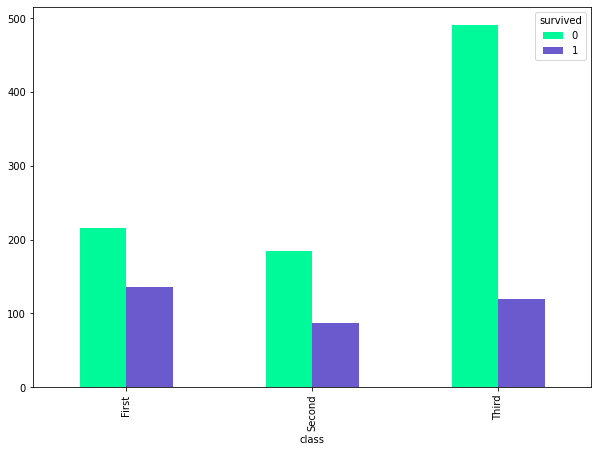

In [543]:
cls_f.plot.bar(figsize=(10, 7), color=['mediumspringgreen', 'slateblue'])

Из этих фреймов и диаграммы можно сделать вывод, что чем меньше класс, тем больше выживаемость(это логично, так как для 1го и 2го класса каюты были выше чем для 3го), в 1й таблице по сравнению со 2й людей с билетами 3го класса сильно больше, а во 2й их количества примерно равны

In [544]:
dck_f = titanic_f.pivot_table(index=['deck'], columns=['survived'], values='pclass', aggfunc='count')
for x in dck_f.index:
    dck_f.loc[x][0] = sum(dck_f.loc[x])
dck_f

survived,0,1
deck,,
A,19,9
B,61,41
C,68,39
D,91,47
E,266,94
F,227,76
G,159,36


In [545]:
for x in dck_f.index:
    print('Палуба {0}, процент выживаемости: {1:2.0f}'.format(x, 100 * dck_f.loc[x][1] / dck_f.loc[x][0]))

Палуба A, процент выживаемости: 47
Палуба B, процент выживаемости: 67
Палуба C, процент выживаемости: 57
Палуба D, процент выживаемости: 52
Палуба E, процент выживаемости: 35
Палуба F, процент выживаемости: 33
Палуба G, процент выживаемости: 23


<AxesSubplot:xlabel='deck'>

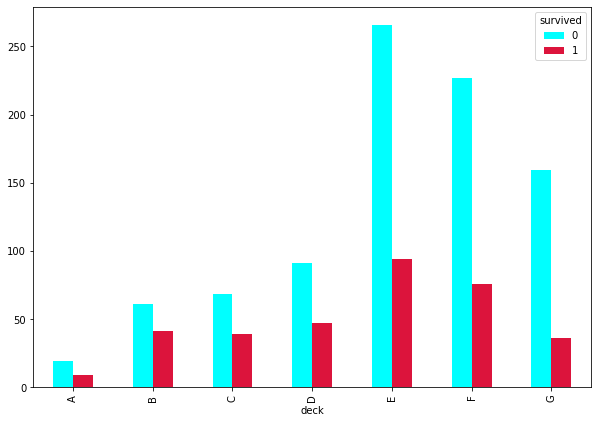

In [546]:
dck_f.plot.bar(figsize=(10, 7), color=['cyan', 'crimson'])

По диаграмме и таблицам понятно, что самая высокая выживаемость была у классов B, C и D, а самая низкая у классов F и G, так как последние находились ниже остальных и были отгорожены от них

Выведем на экран то, как изменилось процентное отношение людей на палубах, так как визуально не очень хорошо видно разницу

In [547]:
for x in dck_f.index:
    print('Палуба {0}, было {1:2.0f}%, стало {2:2.0f}%'.format(x, 100 * dck_f.loc[x][0] / len(titanic_f), 100 * dck_f.loc[x][1] / len(srvd)))

Палуба A, было  2%, стало  3%
Палуба B, было  7%, стало 12%
Палуба C, было  8%, стало 11%
Палуба D, было 10%, стало 14%
Палуба E, было 30%, стало 27%
Палуба F, было 25%, стало 22%
Палуба G, было 18%, стало 11%
